## A tutorial on numba

Code for the tutorial was taken from: https://numba.pydata.org/numba-doc/latest/user/5minguide.html

In [4]:
from numba import njit
import numpy as np
import pandas as pd
from time import time
from timeit import timeit

In [5]:
x = np.arange(1000000).reshape(1000, 1000)

In [6]:
def go_normal(a): # Function is compiled to machine code when called the first time
    trace = 0.0
    for i in range(a.shape[0]):   # Numba likes loops
        trace += np.tanh(a[i, i]) # Numba likes NumPy functions
    return a + trace              # Numba likes NumPy broadcasting

The following will work:

In [7]:
@njit() 
def go_fast(a): # Function is compiled to machine code when called the first time
    trace = 0.0
    for i in range(a.shape[0]):   # Numba likes loops
        trace += np.tanh(a[i, i]) # Numba likes NumPy functions
    return a + trace              # Numba likes NumPy broadcasting


The following will fail:

In [8]:
#x = {'a': [1, 2, 3], 'b': [20, 30, 40]}

#@njit
#def use_pandas(a): # Function will not benefit from Numba jit
#    df = pd.DataFrame.from_dict(a) # Numba doesn't know about pd.DataFrame
#    df += 1                        # Numba doesn't understand what this is
#    return df.cov()                # or this!

#print(use_pandas(x))

In [9]:
start = time()
go_fast(x)
end = time()
print("Elapsed (numba with compilation) = %s" % (end - start))

# NOW THE FUNCTION IS COMPILED, RE-TIME IT EXECUTING FROM CACHE
start = time()
go_fast(x)
end = time()
print("Elapsed (numba after compilation) = %s" % (end - start))


Elapsed (numba with compilation) = 0.5033748149871826
Elapsed (numba after compilation) = 0.0013136863708496094


In [10]:
timeit("go_fast(x)",globals=globals(), number=100)

0.0925998839999238

In [11]:
timeit("go_normal(x)",globals=globals(), number=100)

0.2826867660000971

## Jacobi algorithm in numba

In [12]:
from scipy.spatial.distance import cdist

n = 200
z = 3

def problem(n, z):
    # spot prices
    p = np.random.rand(z)

    # distances
    locs = np.random.normal(size=(z, 2))
    locd, locp = np.random.normal(size=(2, n, 2))
    Dd = cdist(locd, locs) / 25
    Dp = cdist(locp, locs) / 4

    # driver parameters
    lmbda = 10 * np.random.rand(n)

    # passenger parameters
    eps = 20 * np.random.rand(n)

    return p, Dd, Dp, lmbda, eps

p, Dd, Dp, lmbda, eps = problem(n, z)

In [13]:
na = np.newaxis

@njit
def drivers(p, D, lmbda):
    return - lmbda.reshape((-1, 1)) * D + p

@njit
def passengers(p, D, eps):
    return (eps.reshape((-1, 1)) * D) + p


print(drivers(p, Dd, lmbda).shape)
print(passengers(p, Dp, eps).shape)

(200, 3)
(200, 3)


In [5]:
# %timeit (drivers(p, Dd, lmbda).shape)
# %timeit (passengers(p, Dp, eps).shape)

In [14]:
from numba import prange


def softmax(x, T=1e-1):
    xmax = x.max(axis=1, keepdims=True)
    lx = np.exp((x - xmax) / T)
    return lx / (np.exp(- xmax / T) + lx.sum(axis=-1, keepdims=True))

@njit(fastmath=True)
def softmax(x, T=1e-1):
    xmax = np.empty((x.shape[0], 1), dtype=x.dtype)
    for i in prange(x.shape[0]):
        xmax[i, 0] = x[i].max()

    lx = np.exp((x - xmax) / T)

    lxsum = np.empty((lx.shape[0], 1), dtype=lx.dtype)
    for i in prange(lx.shape[0]):
        lxsum[i, 0] = lx[i].sum()

    return lx / (np.exp(- xmax / T) + lxsum)

@njit
def supply(p, D, lmbda):
    u = drivers(p, D, lmbda)
    return softmax(u).T.sum(axis=1)

@njit
def demand(p, D, eps):
    c = passengers(p, D, eps)
    return softmax(- c).T.sum(axis=1)


print(supply(p, Dd, lmbda).shape)
print(demand(p, Dp, eps).shape)

(3,)
(3,)


In [17]:
%timeit (supply(p, Dd, lmbda))
%timeit (demand(p, Dp, eps))

28.5 µs ± 181 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
30.8 µs ± 81.3 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [16]:
from numba import prange


@njit
def Q(p):
    return supply(p, Dd, lmbda) - demand(p, Dp, eps)

def optimize(p, Dd, Dp, lmbda, eps, rtol=1e-18, maxit=10000):
    p = p.copy()
    def q(p):
        return supply(p, Dd, lmbda) - demand(p, Dp, eps)

    sh = 1e-6
    h = np.eye(p.shape[0]) * sh

    for _ in range(maxit):
        pc = p.copy()
        for s in prange(p.shape[0]):
            pc[s] = p[s] - 2 * sh * q(p)[s] / (q(p + h[s]) - q(p - h[s]))[s]
        
        if np.sum((pc - p) ** 2) < rtol:
            break

        p[:] = pc
    
    return pc


soptimize = njit(parallel=False, fastmath=True)(optimize)
poptimize = njit(parallel=True, fastmath=True)(optimize)

op = soptimize(p, Dd, Dp, lmbda, eps)
op = poptimize(p, Dd, Dp, lmbda, eps)

<BarContainer object of 3 artists>

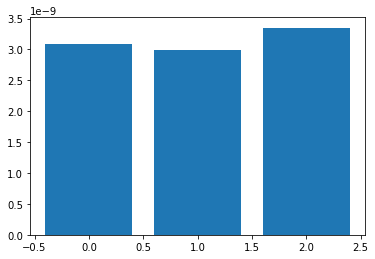

In [18]:
import matplotlib.pyplot as plt

op = poptimize(p, Dd, Dp, lmbda, eps)
plt.bar(range(len(p)), Q(op))

In [19]:
zz = (1, 3, 5, 10, 20, 30, 40, 50, 75, 100, 125, 150)

scurve = {}
for z in zz:
    args = problem(n, z)
    res = %timeit -o soptimize(*args)
    scurve[z] = res.average

536 µs ± 4.89 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
10.8 ms ± 51.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
31.3 ms ± 228 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
115 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
575 ms ± 2.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.35 s ± 5.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.85 s ± 32.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.15 s ± 38.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
13.3 s ± 48.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
24.3 s ± 154 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
42.6 s ± 233 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
57.6 s ± 175 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
pcurve = {}
for z in zz:
    args = problem(n, z)
    res = %timeit -o poptimize(*args)
    pcurve[z] = res.average

1.4 ms ± 79 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
5.85 ms ± 47 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.5 ms ± 153 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
20.6 ms ± 197 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
47.8 ms ± 551 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
93.2 ms ± 6.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
147 ms ± 350 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
194 ms ± 2.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
630 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
835 ms ± 2.74 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.22 s ± 33.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.25 s ± 97.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
np.array([scurve[z] for z in zz]) / np.array([pcurve[z] for z in zz])

array([ 0.38385   ,  1.85030143,  2.96461988,  5.60037699, 12.03169969,
       14.46391057, 19.41783922, 26.59727057, 21.10387908, 29.0863144 ,
       34.91393295, 25.5952356 ])

<AxesSubplot:>

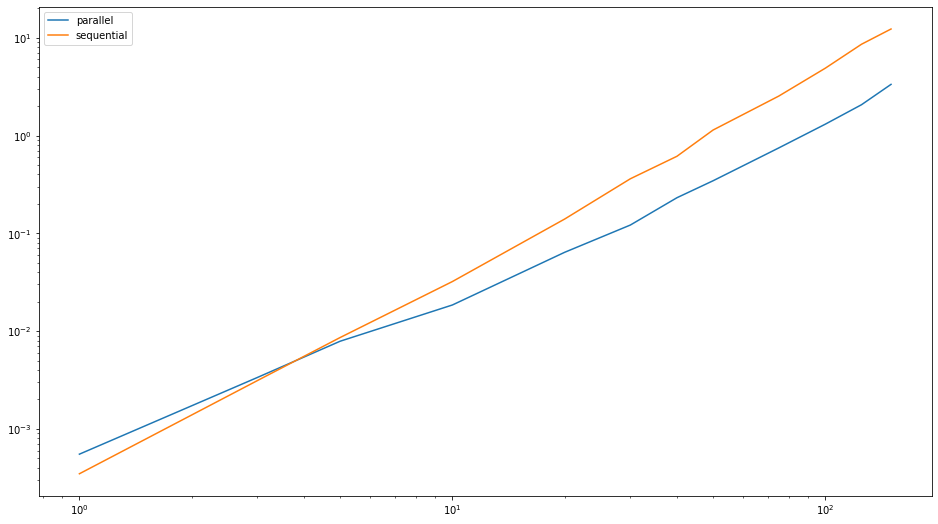

In [50]:
import pandas as pd

df = pd.DataFrame({'parallel': pcurve, 'sequential': scurve})
df.plot(loglog=True, figsize=(16, 9))